<h1 align="center">Ideal Step Size Estimation for the Multinomial Logistic Regression</h1>

# Average Step Sizes

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Epoch 1, loss: 2.0115515231476415, accuracy: 26.554%
Epoch 2, loss: 1.8673189966879842, accuracy: 32.556000000000004%
Epoch 3, loss: 1.7592945790961576, accuracy: 35.839999999999996%
Epoch 4, loss: 1.6923119149854422, accuracy: 38.212%
Epoch 5, loss: 1.6353829123479935, accuracy: 40.242%
Epoch 6, loss: 1.610986453188045, accuracy: 40.928%
Epoch 7, loss: 1.6118503781535742, accuracy: 40.64%
Epoch 8, loss: 1.514384095016343, accuracy: 45.228%
Epoch 9, loss: 1.500688043091913, accuracy: 45.078%
Epoch 10, loss: 1.3891068550631822, accuracy: 50.074%
Epoch 11, loss: 1.3558573268563545, accuracy: 51.498%
Epoch 12, loss: 1.4799195351198202, accuracy: 47.760000000000005%
Epoch 13, loss: 1.271492883677373, accuracy: 54.559999999999995%
Epoch 14, loss: 1.2580510490690655, accuracy: 55.26%
Epoch 15, loss: 1.2062132712215414, accuracy: 57.465999999999994%
Epoch 16, loss: 1.151365692200868, accuracy: 58.867

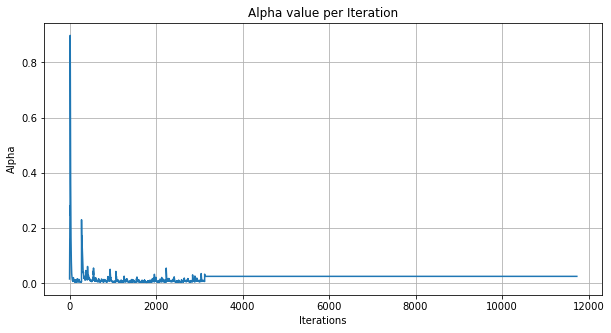

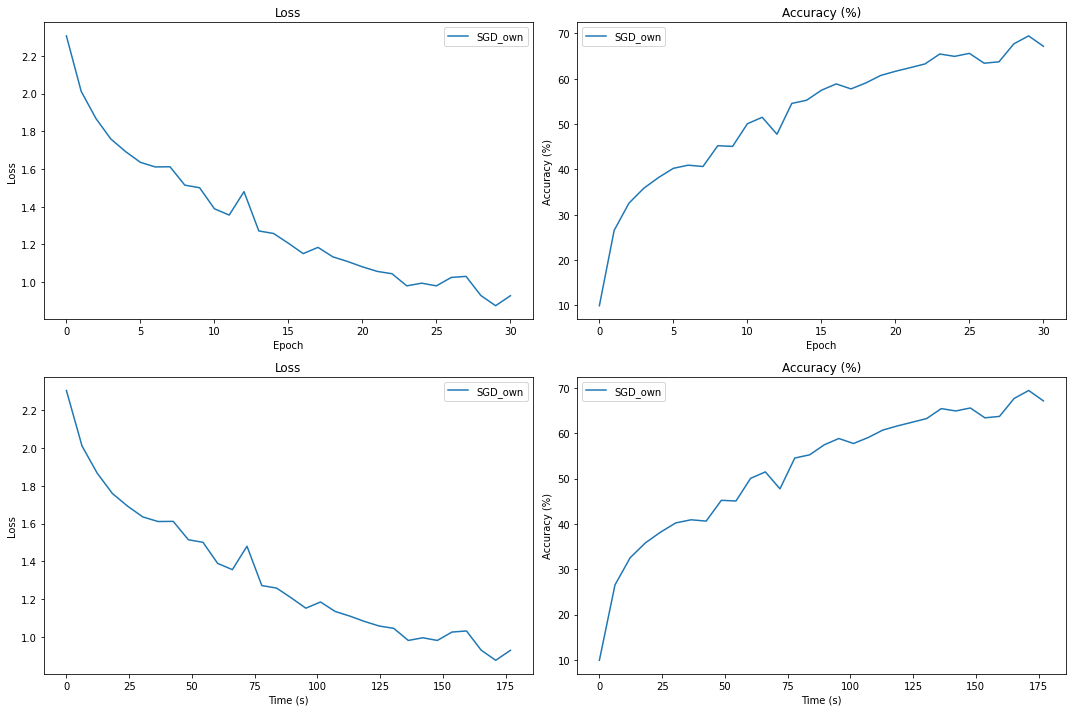

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
import time

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 1

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.0001
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()

    if compute_step_size.avg_step_size > 1:
        compute_step_size.avg_step_size = 1.0
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 


    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr = compute_step_size(X, W, gradient, Y_hot)
    
        self.alphas.append(lr)
        #print(f"Alpha: {lr:.4f}")
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(d_p, alpha=-lr)

        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        self.features_before_fc3 = F.relu(self.fc2(x))
        x = self.fc3(self.features_before_fc3)
        return F.log_softmax(x, dim=1)

    

def evaluate_model(model, loader, criterion):
    
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100

    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = Net().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))
    
    start_time = time.time()
    epoch_losses = []
    epoch_accuracies = []
    time_points = []

    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(30):
        if epoch == 8:
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc3
            W = model.fc3.weight.data
            gradient = model.fc3.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            

        epoch_loss, epoch_accuracy = evaluate_model(model, trainloader, criterion)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        time_points.append(time.time() - start_time)

        print(f'Epoch {epoch + 1}, loss: {epoch_loss}, accuracy: {epoch_accuracy}%')

    print('Training finished. Time elapsed: ', time.time() - start_time)
    history[name] = {'loss': epoch_losses, 'accuracy': epoch_accuracies, 'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()
    
    
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

for name, hist in history.items():
    ax1.plot(hist['loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()

    ax3.plot(hist['time'], hist['loss'], label=name)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss')
    ax3.legend()

    ax4.plot(hist['time'], hist['accuracy'], label=name)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Accuracy (%)')
    ax4.legend()

plt.tight_layout()
plt.show()

# Average Step Sizes, max step before EMA

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Epoch 1, loss: 2.005031734171426, accuracy: 25.892%
Epoch 2, loss: 1.9279115297605314, accuracy: 29.346%
Epoch 3, loss: 1.7960235956684707, accuracy: 34.476%
Epoch 4, loss: 1.6995674420500655, accuracy: 38.436%
Epoch 5, loss: 1.63197521480453, accuracy: 40.658%
Epoch 6, loss: 1.5693158319844005, accuracy: 43.104%
Epoch 7, loss: 1.5301888171974045, accuracy: 43.87%
Epoch 8, loss: 1.5179566080917788, accuracy: 44.956%
Epoch 9, loss: 1.473769598604773, accuracy: 46.646%
Epoch 10, loss: 1.4406662868416829, accuracy: 47.862%
Epoch 11, loss: 1.4177307725867347, accuracy: 48.902%
Epoch 12, loss: 1.3990400776533825, accuracy: 49.584%
Epoch 13, loss: 1.4012311373830146, accuracy: 49.268%
Epoch 14, loss: 1.3960282128790151, accuracy: 49.58%
Epoch 15, loss: 1.370346295559193, accuracy: 50.404%
Epoch 16, loss: 1.3543202547770936, accuracy: 50.804%
Epoch 17, loss: 1.3464709117894282, accuracy: 51.888%
Epoc

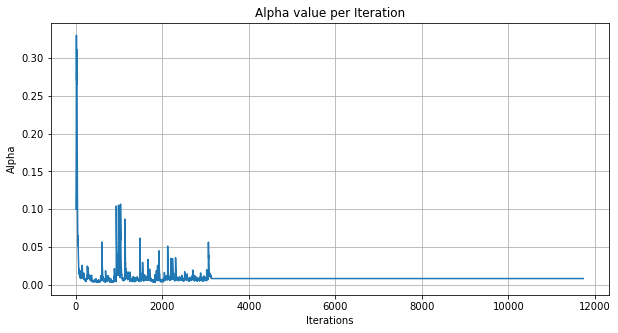

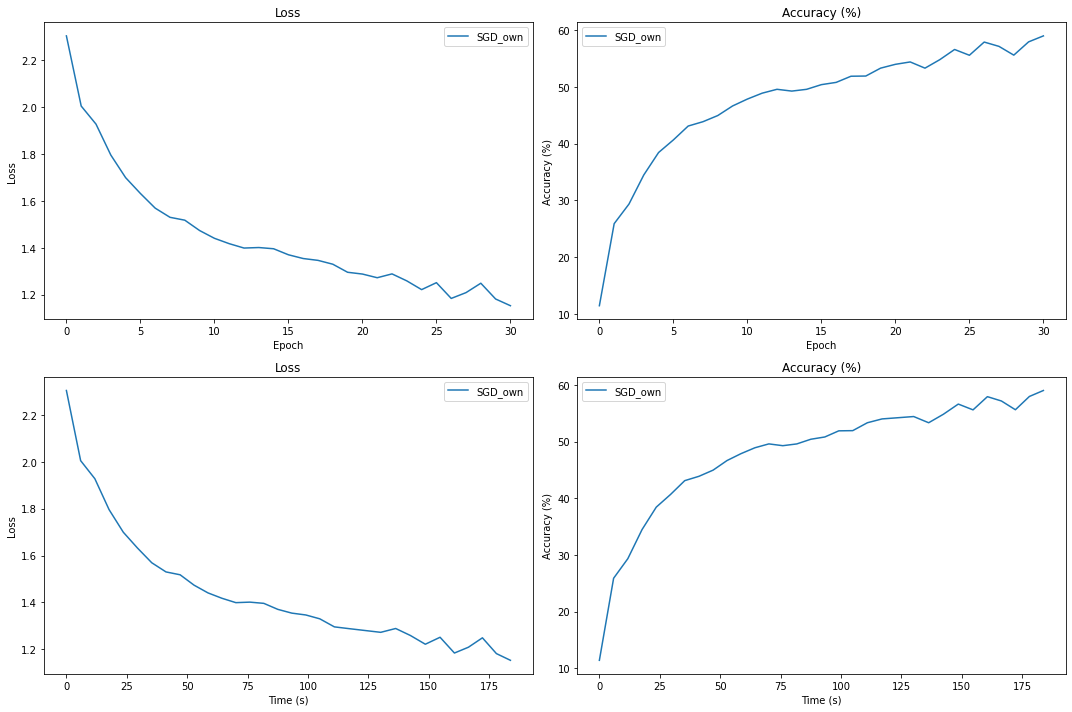

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
import time

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 1

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.0001
    
    alpha = torch.clamp(alpha, 0.00005, 1.0)  
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
    

        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()


    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 


    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr = compute_step_size(X, W, gradient, Y_hot)
    
        self.alphas.append(lr)
        #print(f"Alpha: {lr:.4f}")
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(d_p, alpha=-lr)

        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        self.features_before_fc3 = F.relu(self.fc2(x))
        x = self.fc3(self.features_before_fc3)
        return F.log_softmax(x, dim=1)

    

def evaluate_model(model, loader, criterion):
    
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100

    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = Net().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))
    
    start_time = time.time()
    epoch_losses = []
    epoch_accuracies = []
    time_points = []

    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(30):
        if epoch == 8:
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc3
            W = model.fc3.weight.data
            gradient = model.fc3.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            

        epoch_loss, epoch_accuracy = evaluate_model(model, trainloader, criterion)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        time_points.append(time.time() - start_time)

        print(f'Epoch {epoch + 1}, loss: {epoch_loss}, accuracy: {epoch_accuracy}%')

    print('Training finished. Time elapsed: ', time.time() - start_time)
    history[name] = {'loss': epoch_losses, 'accuracy': epoch_accuracies, 'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()
    
    
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

for name, hist in history.items():
    ax1.plot(hist['loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()

    ax3.plot(hist['time'], hist['loss'], label=name)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss')
    ax3.legend()

    ax4.plot(hist['time'], hist['accuracy'], label=name)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Accuracy (%)')
    ax4.legend()

plt.tight_layout()
plt.show()

# Multiclass Step Sizes

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Epoch 1, loss: 2.2961909649012338, accuracy: 18.378%
Epoch 2, loss: 2.263851194430495, accuracy: 20.735999999999997%
Epoch 3, loss: 2.0895318613027976, accuracy: 25.038%
Epoch 4, loss: 1.9721472687123682, accuracy: 29.221999999999998%
Epoch 5, loss: 1.904109600864713, accuracy: 31.331999999999997%
Epoch 6, loss: 1.8326689334171813, accuracy: 34.022000000000006%
Epoch 7, loss: 1.753621249552578, accuracy: 36.246%
Epoch 8, loss: 1.6974201321296984, accuracy: 38.296%
Epoch 9, loss: 1.6823340901328474, accuracy: 39.162%
Epoch 10, loss: 1.646318408839233, accuracy: 40.1%
Epoch 11, loss: 1.5989430539138483, accuracy: 42.576%
Epoch 12, loss: 1.555740413458451, accuracy: 44.0%
Epoch 13, loss: 1.5237554259922192, accuracy: 45.178000000000004%
Epoch 14, loss: 1.506519552386935, accuracy: 45.867999999999995%
Epoch 15, loss: 1.4737013895493334, accuracy: 46.833999999999996%
Epoch 16, loss: 1.4389924923782

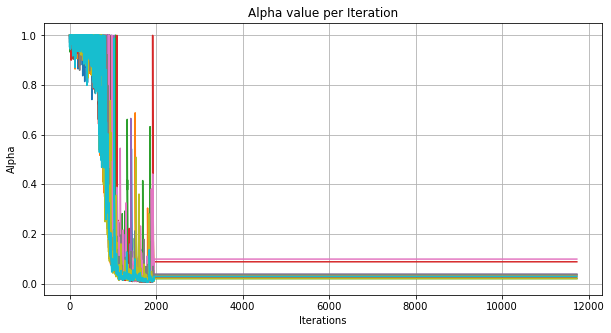

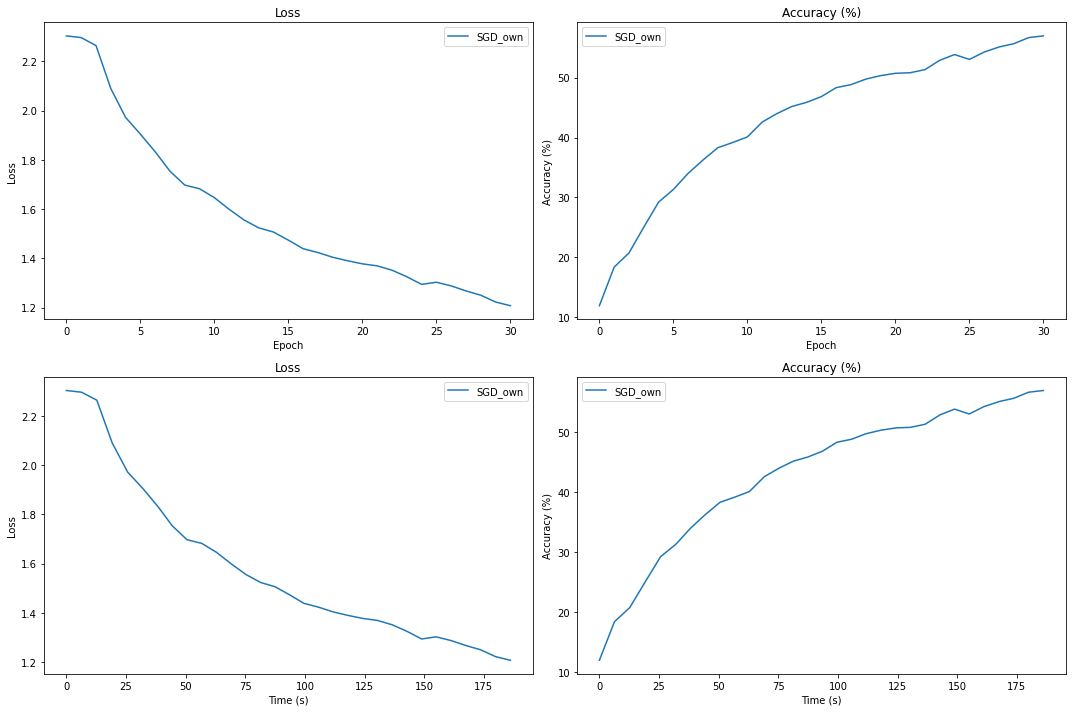

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
import time

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot, Y): 
    global past_10th_epoch

    if past_10th_epoch:
        return torch.ones(10, device=W.device) * compute_step_size.avg_step_size * 2

    
    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)

    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha_from_batch = (torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.001

    alphas_per_class = []
    for class_idx in range(10):
        mask = (Y == class_idx)
        alphas_per_class.append(torch.mean(alpha_from_batch[mask]))

 
        
    alphas = torch.tensor(alphas_per_class, device=W.device)
    
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = torch.ones(10, device=W.device) 
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alphas
    compute_step_size.avg_step_size = torch.clamp(compute_step_size.avg_step_size, 0.00005, 1.0)

    return compute_step_size.avg_step_size


class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 


    def step(self, X, W, gradient, Y_hot, Y):
        loss = None

        alphas = compute_step_size(X, W, gradient, Y_hot, Y)
        self.alphas.append(alphas.cpu().tolist())

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if id(p) == id(model.fc3.weight):
                    for class_idx in range(10):  
                        d_p[class_idx] *= alphas[class_idx]
                p.data.add_(d_p, alpha=-group['lr'])


        return loss




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        self.features_before_fc3 = F.relu(self.fc2(x))
        x = self.fc3(self.features_before_fc3)
        return F.log_softmax(x, dim=1)

    

def evaluate_model(model, loader, criterion):
    
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100

    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = Net().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))
    
    start_time = time.time()
    epoch_losses = []
    epoch_accuracies = []
    time_points = []

    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(30):
        if epoch == 5:
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc3
            W = model.fc3.weight.data
            gradient = model.fc3.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot, labels)
            

        epoch_loss, epoch_accuracy = evaluate_model(model, trainloader, criterion)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        time_points.append(time.time() - start_time)

        print(f'Epoch {epoch + 1}, loss: {epoch_loss}, accuracy: {epoch_accuracy}%')

    print('Training finished. Time elapsed: ', time.time() - start_time)
    history[name] = {'loss': epoch_losses, 'accuracy': epoch_accuracies, 'time': time_points}
    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()
    
    
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

for name, hist in history.items():
    ax1.plot(hist['loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()

    ax3.plot(hist['time'], hist['loss'], label=name)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss')
    ax3.legend()

    ax4.plot(hist['time'], hist['accuracy'], label=name)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Accuracy (%)')
    ax4.legend()

plt.tight_layout()
plt.show()

# Multiclass Step Sizes, max step before EMA

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Epoch 1, loss: 2.300149323690273, accuracy: 12.522%
Epoch 2, loss: 2.292125750685592, accuracy: 17.733999999999998%
Epoch 3, loss: 2.237035022062414, accuracy: 19.246%
Epoch 4, loss: 2.0437995774666673, accuracy: 27.060000000000002%
Epoch 5, loss: 1.9186601925384053, accuracy: 31.408%
Epoch 6, loss: 1.8518437272142572, accuracy: 33.879999999999995%
Epoch 7, loss: 1.7880753681177983, accuracy: 36.012%
Epoch 8, loss: 1.7465239656550804, accuracy: 37.26%
Epoch 9, loss: 1.6963965450711262, accuracy: 39.144%
Epoch 10, loss: 1.6368194635566848, accuracy: 40.64%
Epoch 11, loss: 1.6089808142093747, accuracy: 41.674%
Epoch 12, loss: 1.5624439887073645, accuracy: 43.588%
Epoch 13, loss: 1.541953435334403, accuracy: 44.75%
Epoch 14, loss: 1.5726250931430046, accuracy: 43.519999999999996%
Epoch 15, loss: 1.4879305170625068, accuracy: 46.79%
Epoch 16, loss: 1.4445760634244251, accuracy: 48.07%
Epoch 17, lo

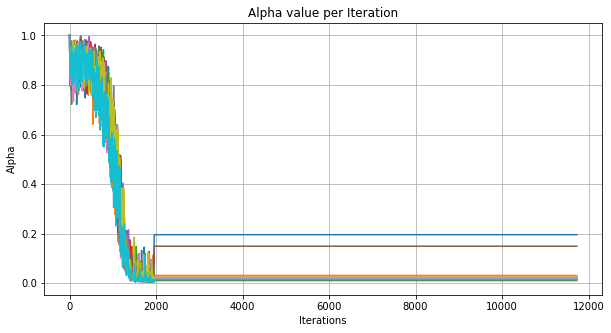

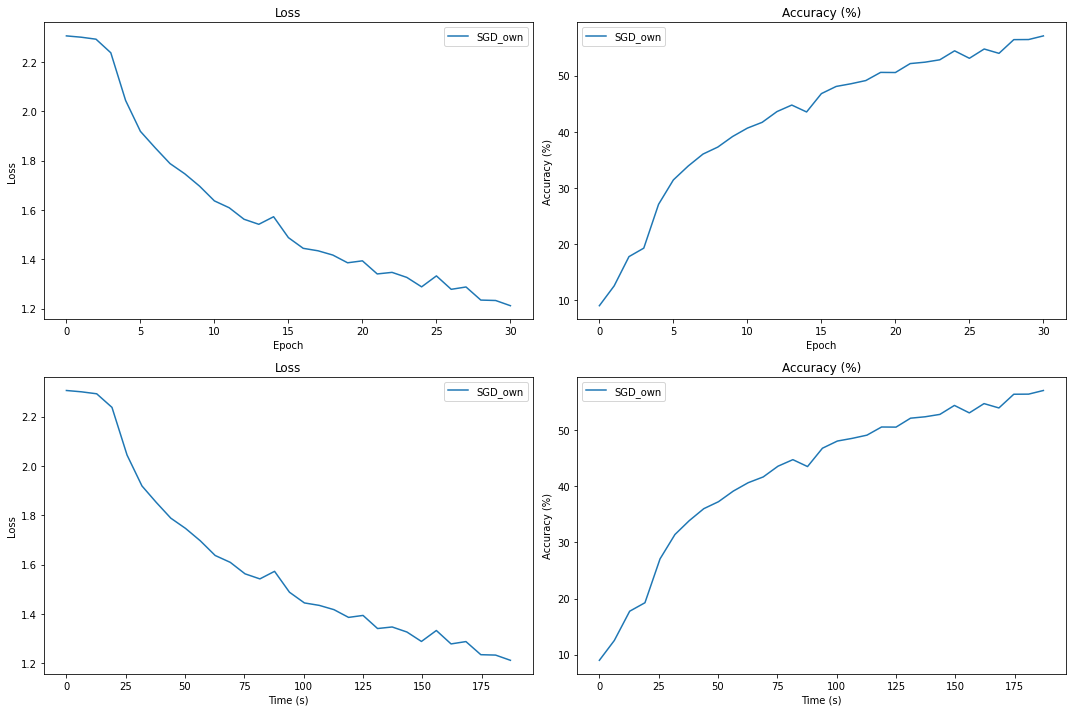

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
import time

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot, Y): 
    global past_10th_epoch

    if past_10th_epoch:
        return torch.ones(10, device=W.device) * compute_step_size.avg_step_size * 2

    
    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)

    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha_from_batch = (torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.001

    alphas_per_class = []
    for class_idx in range(10):
        mask = (Y == class_idx)
        alphas_per_class.append(torch.mean(alpha_from_batch[mask]))

 
        
    alphas = torch.tensor(alphas_per_class, device=W.device)
    alphas = torch.clamp(alphas, 0.00005, 1.0)

    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = torch.ones(10, device=W.device) 
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alphas

    return compute_step_size.avg_step_size


class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 


    def step(self, X, W, gradient, Y_hot, Y):
        loss = None

        alphas = compute_step_size(X, W, gradient, Y_hot, Y)
        self.alphas.append(alphas.cpu().tolist())

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if id(p) == id(model.fc3.weight):
                    for class_idx in range(10):  
                        d_p[class_idx] *= alphas[class_idx]
                p.data.add_(d_p, alpha=-group['lr'])


        return loss




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        self.features_before_fc3 = F.relu(self.fc2(x))
        x = self.fc3(self.features_before_fc3)
        return F.log_softmax(x, dim=1)

    

def evaluate_model(model, loader, criterion):
    
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100

    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = Net().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))
    
    start_time = time.time()
    epoch_losses = []
    epoch_accuracies = []
    time_points = []

    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(30):
        if epoch == 5:
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc3
            W = model.fc3.weight.data
            gradient = model.fc3.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot, labels)
            

        epoch_loss, epoch_accuracy = evaluate_model(model, trainloader, criterion)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        time_points.append(time.time() - start_time)

        print(f'Epoch {epoch + 1}, loss: {epoch_loss}, accuracy: {epoch_accuracy}%')

    print('Training finished. Time elapsed: ', time.time() - start_time)
    history[name] = {'loss': epoch_losses, 'accuracy': epoch_accuracies, 'time': time_points}
    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()
    
    
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

for name, hist in history.items():
    ax1.plot(hist['loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()

    ax3.plot(hist['time'], hist['loss'], label=name)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss')
    ax3.legend()

    ax4.plot(hist['time'], hist['accuracy'], label=name)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Accuracy (%)')
    ax4.legend()

plt.tight_layout()
plt.show()

# Resnet18 ISSE Step Size

Files already downloaded and verified
Files already downloaded and verified
---- SGD_own ----
Test Epoch 1, loss: 2.288228759282752, accuracy: 16.09%
Test Epoch 2, loss: 2.1556079085869126, accuracy: 22.12%
Test Epoch 3, loss: 2.0534855459309833, accuracy: 26.040000000000003%
Test Epoch 4, loss: 1.973258705078801, accuracy: 29.18%
Test Epoch 5, loss: 1.8958320904381667, accuracy: 31.69%
Test Epoch 6, loss: 1.8249407901039607, accuracy: 34.55%
Test Epoch 7, loss: 1.740348838552644, accuracy: 37.19%
Test Epoch 8, loss: 1.689649379706081, accuracy: 38.800000000000004%
Test Epoch 9, loss: 1.6711755070505263, accuracy: 39.77%
Test Epoch 10, loss: 1.6020589448228668, accuracy: 41.52%
Test Epoch 11, loss: 1.564862314658829, accuracy: 43.19%
Test Epoch 12, loss: 1.5718437372883665, accuracy: 42.99%
Test Epoch 13, loss: 1.4934791024727156, accuracy: 45.85%
Test Epoch 14, loss: 1.473943219909185, accuracy: 46.71%
Test Epoch 15, loss: 1.461664453337464, accuracy: 47.46%
Test Epoch 16, loss: 1.292

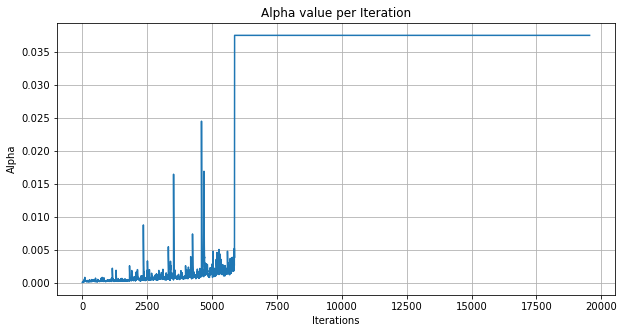

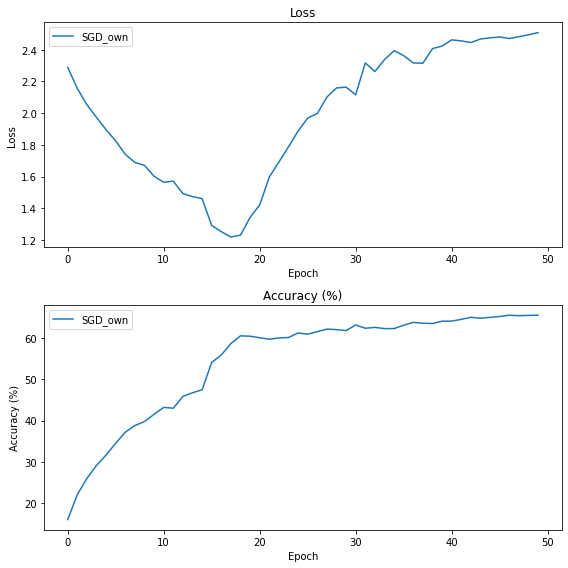

In [22]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 10 ###############################

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.00005
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()

    if compute_step_size.avg_step_size > 0.1:          #############################
        compute_step_size.avg_step_size = 0.1
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 

    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr_last_layer = compute_step_size(X, W, gradient, Y_hot)
        lr_first_layer = lr_last_layer * 0.1  # Scaling first layer #################
        
        self.alphas.append(lr_last_layer)
        
        num_layers = len(self.param_groups[0]['params'])
        
        for group in self.param_groups:
            for idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Linear interpolation of the learning rate based on the layer index
                lr_scale = idx / (num_layers - 1)
                lr_current_layer = lr_first_layer + lr_scale * (lr_last_layer - lr_first_layer)
                
                p.data.add_(d_p, alpha=-lr_current_layer)
        
        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Wrapper(nn.Module):
    def __init__(self):
        super(ResNet18Wrapper, self).__init__()
        self.resnet = resnet18(weights=None)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)  # 10 classes CIFAR10

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        self.features_before_fc = x
        x = self.resnet.fc(self.features_before_fc)
        return F.log_softmax(x, dim=1)
    

def evaluate_model(model, loader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100
    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = ResNet18Wrapper().to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01),
}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    epoch_losses = []
    epoch_accuracies = []
    time_points = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    
    start_time = time.time()
    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)
    
    past_10th_epoch = False

            
    for epoch in range(50):
        if epoch == 15: ##################################################################################
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            X = model.features_before_fc
            W = model.resnet.fc.weight.data  # This is the last layer's weight
            gradient = model.resnet.fc.weight.grad.data
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)
            
            

        test_epoch_loss, test_epoch_accuracy = evaluate_model(model, testloader, criterion)
        test_epoch_losses.append(test_epoch_loss)
        test_epoch_accuracies.append(test_epoch_accuracy)
        print(f'Test Epoch {epoch + 1}, loss: {test_epoch_loss}, accuracy: {test_epoch_accuracy}%')
        
    print('Training finished. Time elapsed: ', time.time() - start_time)
    
    history[name] = {'train_loss': epoch_losses, 
                     'train_accuracy': epoch_accuracies, 
                     'test_loss': test_epoch_losses, 
                     'test_accuracy': test_epoch_accuracies, 
                     'time': time_points}

    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()
    
    
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

for name, hist in history.items():
    ax1.plot(hist['test_loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['test_accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()


plt.tight_layout()
plt.show()

# VGG16 ISSE Step Size

In [ ]:
from torchvision import models
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torchvision import transforms, datasets

gamma = 0.9

def compute_step_size(X, W, gradient, Y_hot):
    global past_10th_epoch

    if past_10th_epoch:
        return compute_step_size.avg_step_size * 1

    W = W.t()
    gradient = gradient.t()
    term1 = torch.sum(torch.exp(-torch.mm(X, W)), dim=1)
    term2 = torch.sum(torch.mm(X, gradient), dim=1)
    term3 = torch.exp(-torch.sum(X * (torch.mm(Y_hot, torch.transpose(W, 0, 1))), dim=1))
    term4 = torch.sum(X * (torch.mm(Y_hot, torch.transpose(gradient, 0, 1))), dim=1)
    
    a = ((term1 * (term2**2)) - (term3 * (term4**2))) / 2
    b = (term1 * term2) - (term3 * term4)
    c = (term1 - term3) - ((term2 * term1 / term4) - (term3))

    alpha = torch.mean(torch.abs((-b + torch.sqrt(b**2 - 4*a*c)) / (2*a))) * 0.0001
    if not hasattr(compute_step_size, "avg_step_size"):
        compute_step_size.avg_step_size = 0
        
    compute_step_size.avg_step_size = gamma * compute_step_size.avg_step_size + (1 - gamma) * alpha.item()

    if compute_step_size.avg_step_size > 1:
        compute_step_size.avg_step_size = 1.0
    
    return compute_step_size.avg_step_size

class SGD_own(Optimizer):
    def __init__(self, params, lr=1e-2):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD_own, self).__init__(params, defaults)
        self.alphas = [] 


    def step(self, X, W, gradient, Y_hot, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        lr = compute_step_size(X, W, gradient, Y_hot)
    
        self.alphas.append(lr)
        #print(f"Alpha: {lr:.4f}")
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(d_p, alpha=-lr)

        return loss


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        self.features_before_fc3 = F.relu(self.fc2(x))
        x = self.fc3(self.features_before_fc3)
        return F.log_softmax(x, dim=1)

    

def evaluate_model(model, loader, criterion):
    
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(loader)
        avg_accuracy = correct / total * 100

    return avg_loss, avg_accuracy



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = models.vgg16(pretrained=False, num_classes=10).to(device)
original_model_state = copy.deepcopy(model.state_dict())

criterion = nn.CrossEntropyLoss()
initial_loss, initial_accuracy = evaluate_model(model, trainloader, criterion)

optimizers = {'SGD_own': SGD_own(model.parameters(), lr=0.01)}


history = {}

for name, optimizer in optimizers.items():
    print(f'---- {name} ----')
    model.load_state_dict(copy.deepcopy(original_model_state))

    start_time = time.time()
    epoch_losses = []
    epoch_accuracies = []
    time_points = []

    epoch_losses.append(initial_loss)
    epoch_accuracies.append(initial_accuracy)
    time_points.append(0)

    past_10th_epoch = False

    for epoch in range(30):
        if epoch == 8:
            past_10th_epoch = True
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Extract features and gradients from the last fully connected layer (classifier[6] in VGG16)
            X = model.classifier[-3].output  # Assuming ReLU is used after this layer
            W = model.classifier[-1].weight.data  # The weight of the last layer in classifier
            gradient = model.classifier[-1].weight.grad.data  # The gradient of the last layer in classifier
            Y_hot = F.one_hot(labels, num_classes=10).float()

            optimizer.step(X, W, gradient, Y_hot)

        epoch_loss, epoch_accuracy = evaluate_model(model, trainloader, criterion)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        time_points.append(time.time() - start_time)

        print(f'Epoch {epoch + 1}, loss: {epoch_loss}, accuracy: {epoch_accuracy}%')

    print('Training finished. Time elapsed: ', time.time() - start_time)
    history[name] = {'loss': epoch_losses, 'accuracy': epoch_accuracies, 'time': time_points}


    
plt.figure(figsize=(10, 5))
plt.plot(optimizers['SGD_own'].alphas)
plt.xlabel('Iterations')
plt.ylabel('Alpha')
plt.title('Alpha value per Iteration')
plt.grid(True)
plt.show()
    
    
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

for name, hist in history.items():
    ax1.plot(hist['loss'], label=name)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(hist['accuracy'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy (%)')
    ax2.legend()

    ax3.plot(hist['time'], hist['loss'], label=name)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss')
    ax3.legend()

    ax4.plot(hist['time'], hist['accuracy'], label=name)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Accuracy (%)')
    ax4.legend()

plt.tight_layout()
plt.show()